In [1]:
import scanpy as sc
from scipy.linalg import svd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
import seaborn as sb
from sys import getsizeof
from math import log
import time
from statistics import mean, stdev
from scipy.stats import norm
import pickle
from sklearn.mixture import GaussianMixture as GMM
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import rpy2.rinterface_lib.callbacks
import logging
from IPython.display import display
import os
import time
start = time.time()
from statistics import mean, stdev
from scipy.stats import norm

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import anndata2ri
import warnings

warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# load R packages
ro.r('.libPaths()')
ro.r('library(clValid)')
ro.r('library(scran)')
ro.r('library(RColorBrewer)')
ro.r('library(slingshot)')
ro.r('library(monocle)')
ro.r('library(gam)')
ro.r('library(clusterExperiment)')
ro.r('library(ggplot2)')
ro.r('library(plyr)')
ro.r('library(MAST)')
ro.r('library(kohonen)')

array(['kohonen', 'MAST', 'plyr', 'clusterExperiment', 'gam', 'foreach',
       'monocle', 'DDRTree', 'irlba', 'VGAM', 'splines', 'ggplot2',
       'Matrix', 'slingshot', 'princurve', 'RColorBrewer', 'scran',
       'SingleCellExperiment', 'SummarizedExperiment', 'DelayedArray',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'BiocParallel', 'clValid', 'cluster', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U20')

# User inputs

In [2]:
k_min = 3 
k_max = 25 
k_step = 1 
data_loc = '/Users/pk/Data/' 
hvg_bool_filename =  'bool_Luecken_pp_Seurat_hvg_manual_3200'
num_obs_keep = 2000  

In [3]:
k_range = range(k_min, k_max + 1, k_step)

In [4]:
hvg_bool_file = data_loc + hvg_bool_filename + '.pickle'
data_file = data_loc + "adata_Luecken_compressed.h5ad"
adata = sc.read(data_file)
with open(hvg_bool_file, 'rb') as handle:
    hvg_bool = pickle.load(handle)

In [5]:
hvg_mx = adata.X[:num_obs_keep, hvg_bool] # reduce number of observations for RAM

In [6]:
# Singular-value decomposition
start = time.time()
U, s, _ = svd(hvg_mx)
print("Runtime:", time.time()-start) #

Runtime: 4.642271041870117


#### Plot all eigenvectors to choose number to keep

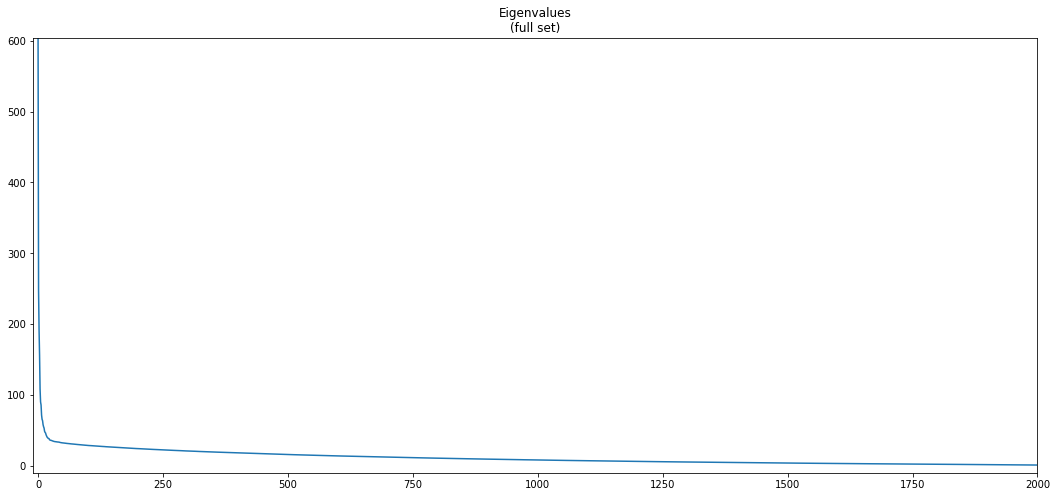

In [7]:
plt.figure(figsize = (18,8))
plt.axis([-10, hvg_mx.shape[0], -10, max(s)])
plt.title("Eigenvalues\n(full set)")
plt.plot(s)

#### Zoom in on elbow

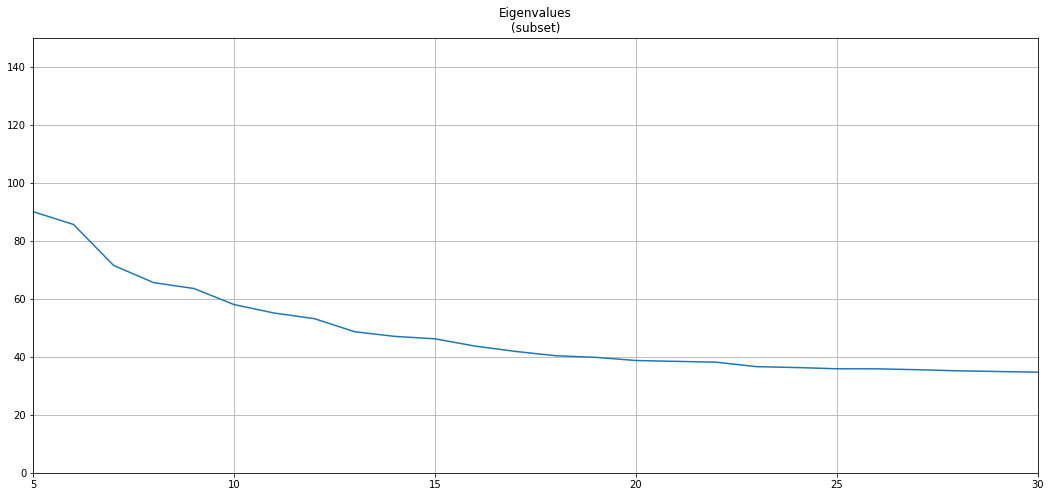

In [8]:
plt.figure(figsize = (18,8))
plt.axis([5, 30, 0, 150])
plt.grid(True)
plt.title("Eigenvalues\n(subset)")
plt.plot(s)

# User Inputs
#### Manually select number of eigenvectors

In [9]:
num_eigenvecs =  13 

#### Remove some eigenvectors

In [10]:
print(U.shape)
reduced_hvg_mx = U[:, :num_eigenvecs]
print(reduced_hvg_mx.shape)
print(s.shape)
s=s[:num_eigenvecs]
print(s.shape)

(2000, 2000)
(2000, 13)
(2000,)
(13,)


#### Reduce RAM

In [11]:
del adata, U

#### Save reduced U and reduced s (as a vector)

In [12]:
U_datafile = data_loc + 'U_reduced_' + hvg_bool_filename + '_numEigens_' + str(num_eigenvecs) + "_obs_" + str(reduced_hvg_mx.shape[0]) + '.pickle'
with open(U_datafile, 'wb') as handle:
    pickle.dump(reduced_hvg_mx, handle)
    
s_datafile = data_loc + 's_reduced_' + hvg_bool_filename + '_numEigens_' + str(num_eigenvecs) + "_obs_" + str(reduced_hvg_mx.shape[0]) + '.pickle'
with open(s_datafile, 'wb') as handle:
    pickle.dump(s, handle)

#### Prepare data for calling R

In [13]:
nr, nc = reduced_hvg_mx.shape
xvec = ro.FloatVector(reduced_hvg_mx.transpose().reshape((reduced_hvg_mx.size)))
xr = ro.r.matrix(xvec, nrow=nr, ncol=nc)

#### Call cluster algorithms in R

# ATTENTION: The next cell takes hours to run

Instead, you can load the clValid object two cells further down

In [14]:
# %%R -i xr -i data_loc -i hvg_bool_filename -i k_min -i k_max -i k_step -o cl_obj_eucl


# clmethods <- c("kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny")
# vlmethods = c("internal", "stability")
# cl_obj <- clValid(xr, 
#                        nClust = seq(k_min,k_max,k_step), 
#                        clMethods = clmethods, 
#                        validation = vlmethods, 
#                        maxitems = 20000,
#                        metric = "euclidean", 
#                        verbose = TRUE) 


# cl_obj_eucl = cl_obj
# clv_file_name =paste(data_loc, "cl_obj_eucl_", hvg_bool_filename, ".rds")
# plot_file_name =paste(data_loc, "cl_obj_eucl_", hvg_bool_filename, ".jpg")
# summary_file_name =paste(data_loc, "cl_obj_eucl_SUMMARY_", hvg_bool_filename, ".txt")
# sink(summary_file_name)
# print(summary(cl_obj))
# sink() 
# saveRDS(cl_obj, file=clv_file_name)


# jpeg(plot_file_name)
# plot(cl_obj)
# dev.off()


# Load clValid object (this is for the assessors)

In [15]:
cl_obj_path = data_loc +' cl_obj_eucl_ ' + hvg_bool_filename + ' .rds'

In [16]:
%%R -i cl_obj_path -o cl_obj_eucl
    
cl_obj_eucl <- readRDS(cl_obj_path)

### Display and save summary of cluster metrics

In [17]:
del xr, xvec # was only needed for the R function
# first index is clustering method, second index is number of clusters, 3rd index is parameter 
# use double square brackets
print("Using the Euclidean distance metric ")
ro.r('summary(cl_obj_eucl)')

Using the Euclidean distance metric 

Clustering Methods:
 kmeans hierarchical model sota pam clara diana fanny 

Cluster sizes:
 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

Validation Measures:
                                   3         4         5         6         7         8         9        10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25
                                                                                                                                                                                                                                                                
kmeans       APN              0.0345    0.0804    0.2428    0.3370    0.2798    0.3436    0.3214    0.2068    0.2793    0.2949    0.2348    0.3224    0.3709    0.3008    0.3299    0.3325    0.3639    0.3460    0.4075    0.3991    0.4249    0.4141    0.4339
             A

<rpy2.rinterface.NULLType object at 0x11d107c30> [RTYPES.NILSXP]

#### Create list of lists of cluster labels

In [18]:
num_clusters = len(k_range)
num_clusters_list = list(map(int, ro.r('cl_obj_eucl@nClust'))) # ascending list of number of clusters
num_cl_methods = len(ro.r('cl_obj_eucl@clMethods')) + 1 # plus 1 for GMM
cl_methods = list(ro.r('cl_obj_eucl@clMethods'))
cl_methods.append("GMM")
num_rows = num_clusters * num_cl_methods

#### NB different cluster methods have different names for the cluster labels attribute

In [19]:
cl_df_data = []

for i in range(1, num_cl_methods): # kmeans, hierarchical, model, sota, pam, clara, diana, fanny, GMM
    label_name = 'clustering'
    if i  == 1: # kmeans
        label_name = 'cluster'
    elif i == 3: # model
        label_name = 'classification'
    elif i == 4: #sota
        label_name = 'clust'
    for j in range(int(ro.r('length(cl_obj_eucl@clusterObjs[[1]])') )):
        num_cl  = num_clusters_list[j]
        
        # Euclidean
        if i == 2: #hierarchical
            label_string = 'cutree(cl_obj_eucl@clusterObjs[[2]], k = ' + str(num_cl) + ')'
            labels = ro.r(label_string)
            
        elif i == 7: #diana
            label_string = 'cutree(cl_obj_eucl@clusterObjs[[7]], k = ' + str(num_cl) + ')'
            labels = ro.r(label_string)
            
        else: # "kmeans", "model", "sota", "pam", "clara", "fanny"
            label_string = 'cl_obj_eucl@clusterObjs[[' + str(i) + "]][[" + str(j+1) + "]]$" + label_name
            labels = np.array(list(map(int, ro.r(label_string) )))

        cl_df_data.append(labels)

#### Build Gaussian mixture models and add labels to list of lists

In [20]:
print("Number of models: ", len(cl_df_data))
gmm_models = []
gmm_labels = []
gmm_n_clusters = []
num_gmm_models = len(k_range)

for i  in range(num_gmm_models): 
    gmm_models.append(GMM(n_components=k_range[i]).fit(reduced_hvg_mx))
    labels = gmm_models[i].fit_predict(reduced_hvg_mx)
    labels = [x+1 for x in labels]
    gmm_labels.append(labels)
    gmm_n_clusters.append(k_range[i])
    cl_df_data.append(labels)

Number of models:  184


#### Turn lists of labels into dataframe

In [21]:
num_clusters = len(k_range)
df_labels = pd.DataFrame(cl_df_data, columns=np.arange(len(cl_df_data[0])))
df_labels.insert(0, "num_clusters", pd.Series(np.tile(num_clusters_list, num_cl_methods)))
df_labels.insert(0, 'cl_method', pd.Series(np.repeat(cl_methods, num_clusters)))
print(df_labels.iloc[:4, :4])
print(df_labels.shape)

  cl_method  num_clusters  0  1
0    kmeans             3  1  1
1    kmeans             4  1  1
2    kmeans             5  3  1
3    kmeans             6  1  1
(207, 2002)


#### Example of using a multi-index pandas dataframe

In [22]:
method = 'kmeans'
num_cl = 5
df_labels.index[(df_labels['cl_method'] == method) & (df_labels['num_clusters'] == num_cl)]

Int64Index([2], dtype='int64')

#### Save dataframe of cluster labels for each model, as both pickled-pandas and a csv file

In [23]:
df_datafile = data_loc + 'Cluster_labels_df_' + hvg_bool_filename +  "_obs_" + str(reduced_hvg_mx.shape[0])
with open(df_datafile + '.pickle', 'wb') as handle:
    pickle.dump(df_labels, handle)

df_labels.to_csv(df_datafile + '.csv')

### Calculate and plot power for each model

In [24]:
# to refer to features with a string, eg col2
featureNames = []
for i in range(1, reduced_hvg_mx.shape[1] + 1):
    featureNames.append("col" + str(i))

power_df_data = [] # to hold data before creating a pandas df
    
for row in range(df_labels.shape[0]): # one row for each model (ie method and #clusters)
    num_features = reduced_hvg_mx.shape[1]  # ie number of features in reduced data set
    numClusters = df_labels.iloc[row, 1]

    # to refer to clusters with a string,  eg clu3
    clusterNames = []
    for i in range(1, numClusters + 1):
        clusterNames.append("clu" + str(i))

    # reduced dataset with an extra column at end to show number of cluster this observation is in
    results = pd.DataFrame(reduced_hvg_mx, columns=featureNames)
    results['cluster'] = df_labels.iloc[row, 2:]

    boolDf = pd.DataFrame(columns=clusterNames)

    # make columns of booleans for cluster membership
    # num obs X num clusters
    i = 1
    for clusterName in clusterNames:
        boolDf[clusterName] = (results['cluster'] == i)
        print("Cluster {} contains {} members".format(i, sum(boolDf[clusterName] == True)))
        i += 1

    # for matrix of calculations
    # column for each feature
    # rows for various parameters for each cluster
    rowNames = []
    for i in range(1, numClusters + 1):
        rowNames.append('Mean' + str(i))
        rowNames.append('Sd' + str(i))
        rowNames.append('Above' + str(i))
        rowNames.append('Below' + str(i))
        rowNames.append('Power' + str(i))  # power for this cluster and feature
    rowNames.append('Power')

    clusterStats = pd.DataFrame(index=rowNames, columns=featureNames)

    for i in range(1, numClusters + 1):
        clusterName = clusterNames[i - 1]
        for featureName in featureNames:
            clusterStats.loc['Mean' + str(i), featureName] = np.mean(results.loc[boolDf.loc[:, clusterName], featureName])
            if boolDf.loc[:, clusterName].sum() < 2: # to avoid error if less than two values for this feature/cluster combination
                clusterStats.loc['Sd' + str(i), featureName] = 100 * abs(clusterStats.loc['Mean' + str(i), featureName])
            else:
                clusterStats.loc['Sd' + str(i), featureName] = stdev(results.loc[boolDf.loc[:, clusterName], featureName])
            clusterStats.loc['Above' + str(i), featureName] = 100
            clusterStats.loc['Below' + str(i), featureName] = -100

    for featureName in featureNames:  # for each column
        for targetCluster in range(1, numClusters + 1):  # the cluster we're calculating the power for
            for otherCluster in range(1, numClusters + 1):  # to compare targetCluster mean to each of other cluster means
                if targetCluster == otherCluster: # don't compare cluster to itself
                    continue

                # check each other clusters mean to find closest above
                if clusterStats.loc['Mean' + str(otherCluster), featureName] > clusterStats.loc[
                    'Mean' + str(targetCluster), featureName]:
                    if clusterStats.loc['Mean' + str(otherCluster), featureName] < clusterStats.loc[
                        'Above' + str(targetCluster), featureName]:
                        clusterStats.loc['Above' + str(targetCluster), featureName] = clusterStats.loc[
                            'Mean' + str(otherCluster), featureName]

                # check each other clusters mean to find closest below
                if clusterStats.loc['Mean' + str(otherCluster), featureName] < clusterStats.loc[
                    'Mean' + str(targetCluster), featureName]:
                    if clusterStats.loc['Mean' + str(otherCluster), featureName] > clusterStats.loc[
                        'Below' + str(targetCluster), featureName]:
                        clusterStats.loc['Below' + str(targetCluster), featureName] = clusterStats.loc[
                            'Mean' + str(otherCluster), featureName]

                        
    # calculate power for each cluster & feature combination
    for featureName in featureNames:
        for i in range(1, numClusters + 1):
            upper = clusterStats.loc['Above' + str(i), featureName]
            lower = clusterStats.loc['Below' + str(i), featureName]
            mean = clusterStats.loc['Mean' + str(i), featureName]
            sd = clusterStats.loc['Sd' + str(i), featureName]
            power = norm.cdf(upper, loc=mean, scale=sd) - norm.cdf(lower, loc=mean, scale=sd)
            clusterStats.loc['Power' + str(i), featureName] = power

    # calculate average power for each feature
    for featureName in featureNames:
        sumPower = 0
        for i in range(1, numClusters + 1):
            sumPower += clusterStats.loc['Power' + str(i), featureName]
        clusterStats.loc['Power', featureName] = 100 * sumPower / numClusters

    power_df_data.append(clusterStats.iloc[-1, :])

Cluster 1 contains 1948 members
Cluster 2 contains 22 members
Cluster 3 contains 30 members
Cluster 1 contains 1788 members
Cluster 2 contains 22 members
Cluster 3 contains 160 members
Cluster 4 contains 30 members
Cluster 1 contains 1614 members
Cluster 2 contains 22 members
Cluster 3 contains 246 members
Cluster 4 contains 30 members
Cluster 5 contains 88 members
Cluster 1 contains 1368 members
Cluster 2 contains 22 members
Cluster 3 contains 336 members
Cluster 4 contains 30 members
Cluster 5 contains 156 members
Cluster 6 contains 88 members
Cluster 1 contains 854 members
Cluster 2 contains 85 members
Cluster 3 contains 21 members
Cluster 4 contains 243 members
Cluster 5 contains 30 members
Cluster 6 contains 150 members
Cluster 7 contains 617 members
Cluster 1 contains 739 members
Cluster 2 contains 85 members
Cluster 3 contains 268 members
Cluster 4 contains 22 members
Cluster 5 contains 111 members
Cluster 6 contains 30 members
Cluster 7 contains 140 members
Cluster 8 contains 6

Cluster 1 contains 51 members
Cluster 2 contains 218 members
Cluster 3 contains 67 members
Cluster 4 contains 25 members
Cluster 5 contains 20 members
Cluster 6 contains 199 members
Cluster 7 contains 186 members
Cluster 8 contains 116 members
Cluster 9 contains 155 members
Cluster 10 contains 15 members
Cluster 11 contains 13 members
Cluster 12 contains 21 members
Cluster 13 contains 105 members
Cluster 14 contains 7 members
Cluster 15 contains 130 members
Cluster 16 contains 77 members
Cluster 17 contains 22 members
Cluster 18 contains 27 members
Cluster 19 contains 38 members
Cluster 20 contains 211 members
Cluster 21 contains 20 members
Cluster 22 contains 64 members
Cluster 23 contains 106 members
Cluster 24 contains 107 members
Cluster 1 contains 51 members
Cluster 2 contains 177 members
Cluster 3 contains 51 members
Cluster 4 contains 25 members
Cluster 5 contains 24 members
Cluster 6 contains 173 members
Cluster 7 contains 140 members
Cluster 8 contains 52 members
Cluster 9 con

Cluster 1 contains 114 members
Cluster 2 contains 1523 members
Cluster 3 contains 157 members
Cluster 4 contains 3 members
Cluster 5 contains 59 members
Cluster 6 contains 16 members
Cluster 7 contains 15 members
Cluster 8 contains 16 members
Cluster 9 contains 9 members
Cluster 10 contains 19 members
Cluster 11 contains 20 members
Cluster 12 contains 2 members
Cluster 13 contains 1 members
Cluster 14 contains 2 members
Cluster 15 contains 9 members
Cluster 16 contains 21 members
Cluster 17 contains 6 members
Cluster 18 contains 2 members
Cluster 19 contains 2 members
Cluster 20 contains 1 members
Cluster 21 contains 2 members
Cluster 22 contains 1 members
Cluster 1 contains 114 members
Cluster 2 contains 1523 members
Cluster 3 contains 157 members
Cluster 4 contains 3 members
Cluster 5 contains 59 members
Cluster 6 contains 12 members
Cluster 7 contains 4 members
Cluster 8 contains 15 members
Cluster 9 contains 16 members
Cluster 10 contains 9 members
Cluster 11 contains 19 members
Cl

Cluster 1 contains 125 members
Cluster 2 contains 82 members
Cluster 3 contains 137 members
Cluster 4 contains 141 members
Cluster 5 contains 56 members
Cluster 6 contains 109 members
Cluster 7 contains 84 members
Cluster 8 contains 105 members
Cluster 9 contains 122 members
Cluster 10 contains 164 members
Cluster 11 contains 98 members
Cluster 12 contains 143 members
Cluster 13 contains 153 members
Cluster 14 contains 96 members
Cluster 15 contains 98 members
Cluster 16 contains 90 members
Cluster 17 contains 52 members
Cluster 18 contains 104 members
Cluster 19 contains 20 members
Cluster 20 contains 21 members
Cluster 1 contains 125 members
Cluster 2 contains 77 members
Cluster 3 contains 139 members
Cluster 4 contains 133 members
Cluster 5 contains 58 members
Cluster 6 contains 107 members
Cluster 7 contains 84 members
Cluster 8 contains 115 members
Cluster 9 contains 77 members
Cluster 10 contains 84 members
Cluster 11 contains 123 members
Cluster 12 contains 113 members
Cluster 1

Cluster 1 contains 87 members
Cluster 2 contains 135 members
Cluster 3 contains 11 members
Cluster 4 contains 17 members
Cluster 5 contains 599 members
Cluster 6 contains 259 members
Cluster 7 contains 70 members
Cluster 8 contains 52 members
Cluster 9 contains 5 members
Cluster 10 contains 6 members
Cluster 11 contains 2 members
Cluster 12 contains 2 members
Cluster 13 contains 22 members
Cluster 14 contains 33 members
Cluster 15 contains 621 members
Cluster 16 contains 37 members
Cluster 17 contains 42 members
Cluster 1 contains 87 members
Cluster 2 contains 135 members
Cluster 3 contains 11 members
Cluster 4 contains 17 members
Cluster 5 contains 599 members
Cluster 6 contains 259 members
Cluster 7 contains 70 members
Cluster 8 contains 52 members
Cluster 9 contains 5 members
Cluster 10 contains 6 members
Cluster 11 contains 2 members
Cluster 12 contains 2 members
Cluster 13 contains 22 members
Cluster 14 contains 33 members
Cluster 15 contains 621 members
Cluster 16 contains 37 mem

Cluster 1 contains 103 members
Cluster 2 contains 153 members
Cluster 3 contains 374 members
Cluster 4 contains 208 members
Cluster 5 contains 235 members
Cluster 6 contains 125 members
Cluster 7 contains 84 members
Cluster 8 contains 191 members
Cluster 9 contains 138 members
Cluster 10 contains 101 members
Cluster 11 contains 114 members
Cluster 12 contains 123 members
Cluster 13 contains 28 members
Cluster 14 contains 23 members
Cluster 1 contains 101 members
Cluster 2 contains 153 members
Cluster 3 contains 175 members
Cluster 4 contains 180 members
Cluster 5 contains 299 members
Cluster 6 contains 112 members
Cluster 7 contains 84 members
Cluster 8 contains 186 members
Cluster 9 contains 213 members
Cluster 10 contains 102 members
Cluster 11 contains 111 members
Cluster 12 contains 107 members
Cluster 13 contains 127 members
Cluster 14 contains 28 members
Cluster 15 contains 22 members
Cluster 1 contains 100 members
Cluster 2 contains 98 members
Cluster 3 contains 176 members
Clus

Cluster 1 contains 96 members
Cluster 2 contains 147 members
Cluster 3 contains 453 members
Cluster 4 contains 402 members
Cluster 5 contains 219 members
Cluster 6 contains 534 members
Cluster 7 contains 99 members
Cluster 8 contains 28 members
Cluster 9 contains 22 members
Cluster 1 contains 100 members
Cluster 2 contains 100 members
Cluster 3 contains 307 members
Cluster 4 contains 380 members
Cluster 5 contains 320 members
Cluster 6 contains 147 members
Cluster 7 contains 94 members
Cluster 8 contains 324 members
Cluster 9 contains 206 members
Cluster 10 contains 22 members
Cluster 1 contains 100 members
Cluster 2 contains 117 members
Cluster 3 contains 415 members
Cluster 4 contains 261 members
Cluster 5 contains 263 members
Cluster 6 contains 138 members
Cluster 7 contains 87 members
Cluster 8 contains 501 members
Cluster 9 contains 68 members
Cluster 10 contains 28 members
Cluster 11 contains 22 members
Cluster 1 contains 106 members
Cluster 2 contains 108 members
Cluster 3 conta

Cluster 1 contains 1945 members
Cluster 2 contains 32 members
Cluster 3 contains 23 members
Cluster 1 contains 1859 members
Cluster 2 contains 86 members
Cluster 3 contains 32 members
Cluster 4 contains 23 members
Cluster 1 contains 1701 members
Cluster 2 contains 158 members
Cluster 3 contains 86 members
Cluster 4 contains 32 members
Cluster 5 contains 23 members
Cluster 1 contains 110 members
Cluster 2 contains 1591 members
Cluster 3 contains 158 members
Cluster 4 contains 86 members
Cluster 5 contains 32 members
Cluster 6 contains 23 members
Cluster 1 contains 110 members
Cluster 2 contains 278 members
Cluster 3 contains 1313 members
Cluster 4 contains 158 members
Cluster 5 contains 86 members
Cluster 6 contains 32 members
Cluster 7 contains 23 members
Cluster 1 contains 110 members
Cluster 2 contains 104 members
Cluster 3 contains 1313 members
Cluster 4 contains 158 members
Cluster 5 contains 86 members
Cluster 6 contains 174 members
Cluster 7 contains 32 members
Cluster 8 contains

Cluster 1 contains 77 members
Cluster 2 contains 64 members
Cluster 3 contains 199 members
Cluster 4 contains 317 members
Cluster 5 contains 154 members
Cluster 6 contains 67 members
Cluster 7 contains 79 members
Cluster 8 contains 27 members
Cluster 9 contains 597 members
Cluster 10 contains 174 members
Cluster 11 contains 46 members
Cluster 12 contains 33 members
Cluster 13 contains 33 members
Cluster 14 contains 38 members
Cluster 15 contains 15 members
Cluster 16 contains 22 members
Cluster 17 contains 17 members
Cluster 18 contains 9 members
Cluster 19 contains 4 members
Cluster 20 contains 8 members
Cluster 21 contains 6 members
Cluster 22 contains 10 members
Cluster 23 contains 2 members
Cluster 24 contains 2 members
Cluster 1 contains 77 members
Cluster 2 contains 64 members
Cluster 3 contains 199 members
Cluster 4 contains 317 members
Cluster 5 contains 154 members
Cluster 6 contains 67 members
Cluster 7 contains 79 members
Cluster 8 contains 27 members
Cluster 9 contains 597 

Cluster 1 contains 1921 members
Cluster 2 contains 79 members
Cluster 3 contains 0 members
Cluster 4 contains 0 members
Cluster 5 contains 0 members
Cluster 6 contains 0 members
Cluster 7 contains 0 members
Cluster 8 contains 0 members
Cluster 9 contains 0 members
Cluster 10 contains 0 members
Cluster 11 contains 0 members
Cluster 12 contains 0 members
Cluster 13 contains 0 members
Cluster 14 contains 0 members
Cluster 15 contains 0 members
Cluster 16 contains 0 members
Cluster 17 contains 0 members
Cluster 18 contains 0 members
Cluster 19 contains 0 members
Cluster 20 contains 0 members
Cluster 21 contains 0 members
Cluster 22 contains 0 members
Cluster 1 contains 2000 members
Cluster 2 contains 0 members
Cluster 3 contains 0 members
Cluster 4 contains 0 members
Cluster 5 contains 0 members
Cluster 6 contains 0 members
Cluster 7 contains 0 members
Cluster 8 contains 0 members
Cluster 9 contains 0 members
Cluster 10 contains 0 members
Cluster 11 contains 0 members
Cluster 12 contains 0

Cluster 1 contains 98 members
Cluster 2 contains 201 members
Cluster 3 contains 82 members
Cluster 4 contains 219 members
Cluster 5 contains 248 members
Cluster 6 contains 36 members
Cluster 7 contains 106 members
Cluster 8 contains 31 members
Cluster 9 contains 116 members
Cluster 10 contains 21 members
Cluster 11 contains 208 members
Cluster 12 contains 123 members
Cluster 13 contains 159 members
Cluster 14 contains 48 members
Cluster 15 contains 31 members
Cluster 16 contains 61 members
Cluster 17 contains 26 members
Cluster 18 contains 131 members
Cluster 19 contains 17 members
Cluster 20 contains 38 members
Cluster 1 contains 30 members
Cluster 2 contains 60 members
Cluster 3 contains 21 members
Cluster 4 contains 60 members
Cluster 5 contains 130 members
Cluster 6 contains 203 members
Cluster 7 contains 79 members
Cluster 8 contains 417 members
Cluster 9 contains 38 members
Cluster 10 contains 187 members
Cluster 11 contains 21 members
Cluster 12 contains 22 members
Cluster 13 co

#### Turn list  of lists of power into datframe

In [25]:
df_power = pd.DataFrame(power_df_data, columns=featureNames, index = range(len(power_df_data)))

print(df_power.iloc[:4, :4])
print(df_power.shape)

        col1       col2       col3       col4
0  60.722002  55.581075  46.079997  66.604556
1  72.963077  79.470505  43.487872  80.408794
2  78.147953  93.603185  74.206042  68.698242
3  63.287414  64.329559  53.368913  62.236341
(207, 13)


#### Calculate average power for each cluster

In [26]:
avg_power = []
for i in range(df_power.shape[0]):
    avg_power.append(round(np.mean(df_power.iloc[i, :]),1))
df_power.insert(0, "Average_Power", avg_power)
print(df_power.iloc[:4, :4])
print(df_power.shape)

   Average_Power       col1       col2       col3
0           69.1  60.722002  55.581075  46.079997
1           62.3  72.963077  79.470505  43.487872
2           58.4  78.147953  93.603185  74.206042
3           51.4  63.287414  64.329559  53.368913
(207, 14)


#### Prepend cluster power dataframe with column of cluster method name and number of clusters

In [27]:
num_clusters = len(k_range)
df_power.insert(0, "num_clusters", pd.Series(np.tile(num_clusters_list, num_cl_methods)))
df_power.insert(0, 'cl_method', pd.Series(np.repeat(cl_methods, num_clusters)))
print(df_power.iloc[:4, :4])
print(df_power.shape)

  cl_method  num_clusters  Average_Power       col1
0    kmeans             3           69.1  60.722002
1    kmeans             4           62.3  72.963077
2    kmeans             5           58.4  78.147953
3    kmeans             6           51.4  63.287414
(207, 16)


#### Plot average power for each cluster method and number of clusters

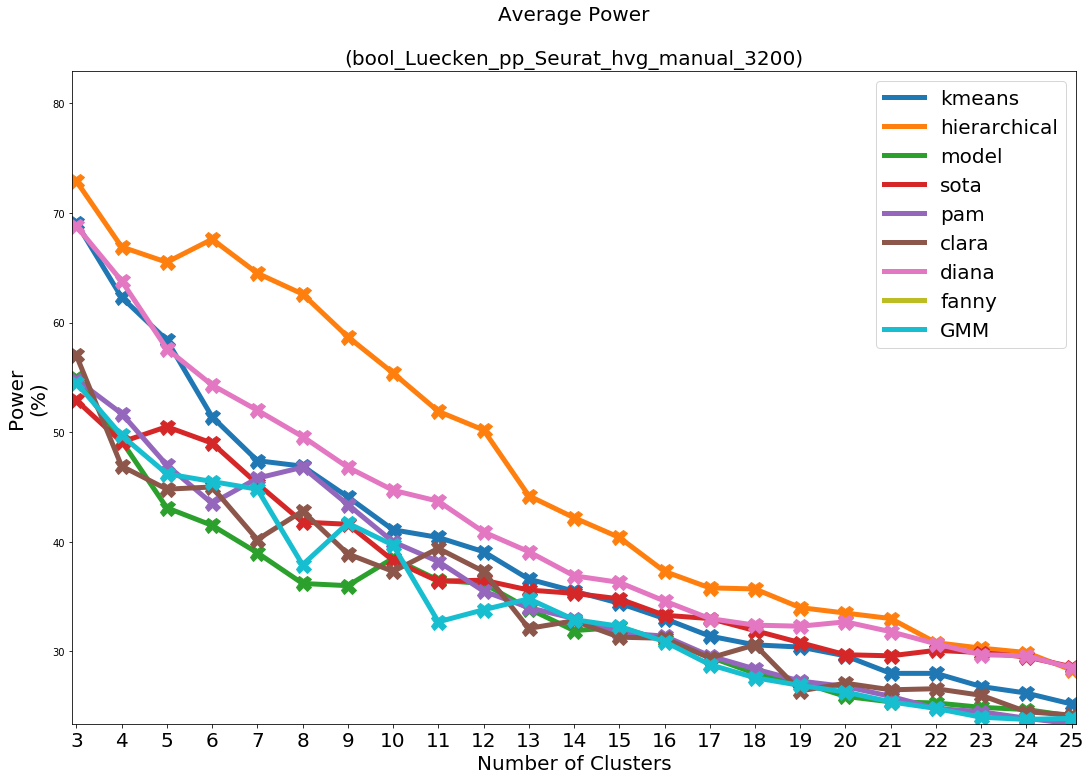

In [28]:
num_clusters = len(k_range)
plt.figure(figsize = (18,12))
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:olive", "tab:cyan"]
max_power = max(df_power.iloc[:, 2])
min_power = min(df_power.iloc[:, 2])
cl_ = k_range[-1] - k_range[0]
plt.axis([-.1, cl_ + .1 , min_power, max_power + 10])

for i in range(num_cl_methods):
    first = i * num_clusters
    last = (i + 1) * num_clusters 
    plt.plot(range(num_clusters), df_power.iloc[first:last, 2], color=colour_list[i], 
             label=df_power.iloc[i*num_clusters, 0], linewidth = 5)
    plt.plot(range(num_clusters), df_power.iloc[first:last, 2], color=colour_list[i], 
             marker='X' , markersize=15, label='_nolegend_')

    
plt.legend(loc='upper right', fontsize = 20)
plt.title('Average Power\n\n({})'.format(hvg_bool_filename), fontsize = 20)

plt.xlabel('Number of Clusters', fontsize = 20)
plt.ylabel('Power\n(%)', fontsize = 20)
plt.xticks(range(num_clusters), num_clusters_list, fontsize = 20)
plot_file_name = data_loc + "avg_pwr_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

#### Calculate AIC and BIC

In [29]:
num_clusters = len(k_range)
df_ic = pd.DataFrame(0, index = np.arange(2*num_clusters), columns=["AIC", "BIC"])
df_ic.shape

(46, 2)

#### Calculate AIC, BIC for Gaussian mixture models

In [30]:
num_obs = reduced_hvg_mx.shape[0]
num_features = reduced_hvg_mx.shape[1]
row_counter =  0
 
for gmm_model in range(num_gmm_models):
    withinss = 0
    for obs_index in range(num_obs):
        label = gmm_labels[gmm_model][obs_index]-1
        cl_mean = gmm_models[gmm_model].means_[label].reshape(1, -1)
        k = gmm_models[gmm_model].n_components
        obs = reduced_hvg_mx[obs_index, :].reshape(1, -1)
        out = cdist(cl_mean, obs, 'sqeuclidean').sum()
        withinss += out
        
    AIC = round(2*withinss + k, 3)
    BIC = round(2*withinss + k*np.log(num_features), 3)
    df_ic.iloc[row_counter, 0] = AIC
    df_ic.iloc[row_counter, 1] = BIC
    print("AIC for GMM model with {} clusters: {}".format(k, AIC))
    print("BIC for GMM model with {} clusters: {}".format(k, BIC))
    print()
    row_counter += 1
    

AIC for GMM model with 3 clusters: 23.895
BIC for GMM model with 3 clusters: 28.59

AIC for GMM model with 4 clusters: 24.204
BIC for GMM model with 4 clusters: 30.463

AIC for GMM model with 5 clusters: 23.485
BIC for GMM model with 5 clusters: 31.31

AIC for GMM model with 6 clusters: 23.531
BIC for GMM model with 6 clusters: 32.921

AIC for GMM model with 7 clusters: 23.406
BIC for GMM model with 7 clusters: 34.361

AIC for GMM model with 8 clusters: 23.394
BIC for GMM model with 8 clusters: 35.914

AIC for GMM model with 9 clusters: 22.575
BIC for GMM model with 9 clusters: 36.66

AIC for GMM model with 10 clusters: 23.053
BIC for GMM model with 10 clusters: 38.703

AIC for GMM model with 11 clusters: 24.19
BIC for GMM model with 11 clusters: 41.404

AIC for GMM model with 12 clusters: 24.605
BIC for GMM model with 12 clusters: 43.385

AIC for GMM model with 13 clusters: 24.23
BIC for GMM model with 13 clusters: 44.575

AIC for GMM model with 14 clusters: 25.1
BIC for GMM model wit

#### Calculate AIC, BIC for K-means model

In [31]:
print("\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
print("AIC and BIC for K-means using the Euclidean distance metric ")
      
num_models = len(ro.r("cl_obj_eucl@clusterObjs[[1]]"))

num_features = reduced_hvg_mx.shape[1]
num_obs = reduced_hvg_mx.shape[0]
for i in range (1, num_models +1):
    temp_string = 'cl_obj_eucl@clusterObjs[[1]][[' + str(i) + ']]'
    ss_string = temp_string + '$tot.withinss'
    ss = float(ro.r(ss_string))
    k_string = 'nrow(' + temp_string + '$centers)'
    k = float(ro.r(k_string))
    AIC = round(2*ss+k, 3)
    BIC = round(2*ss+k*np.log(num_features), 3)
    print("AIC for k-means model with {} clusters: {}".format(k, AIC))
    print("BIC for k-means model with {} clusters: {}".format(k, BIC))
    df_ic.iloc[row_counter, 0] = AIC
    df_ic.iloc[row_counter, 1] = BIC
    row_counter += 1
    print()



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
AIC and BIC for K-means using the Euclidean distance metric 
AIC for k-means model with 3.0 clusters: 23.719
BIC for k-means model with 3.0 clusters: 28.414

AIC for k-means model with 4.0 clusters: 23.007
BIC for k-means model with 4.0 clusters: 29.266

AIC for k-means model with 5.0 clusters: 22.153
BIC for k-means model with 5.0 clusters: 29.977

AIC for k-means model with 6.0 clusters: 22.103
BIC for k-means model with 6.0 clusters: 31.493

AIC for k-means model with 7.0 clusters: 21.861
BIC for k-means model with 7.0 clusters: 32.815

AIC for k-means model with 8.0 clusters: 20.893
BIC for k-means model with 8.0 clusters: 33.412

AIC for k-means model with 9.0 clusters: 21.022
BIC for k-means model with 9.0 clusters: 35.107

AIC for k-means model with 10.0 clusters: 21.189
BIC for k-means model with 10.0 clusters: 36.838

AIC for k-means model with 11.0 clusters: 21.778
BIC for k-means model with 11.0 clusters: 38.9

#### Save AIC, BIC

In [32]:
df_ic.insert(0, "num_clusters", pd.Series(np.tile(num_clusters_list, 2)))
df_ic.insert(0, 'cl_method', pd.Series(np.repeat(["gmm", "kmeans"], num_clusters)))
df_ic

df_datafile = data_loc + 'AIC_BIC_' + hvg_bool_filename +  "_obs_" + str(reduced_hvg_mx.shape[0])
with open(df_datafile + '.pickle', 'wb') as handle:
    pickle.dump(df_ic, handle)

df_ic.to_csv(df_datafile + '.csv')

#### Plot AIC

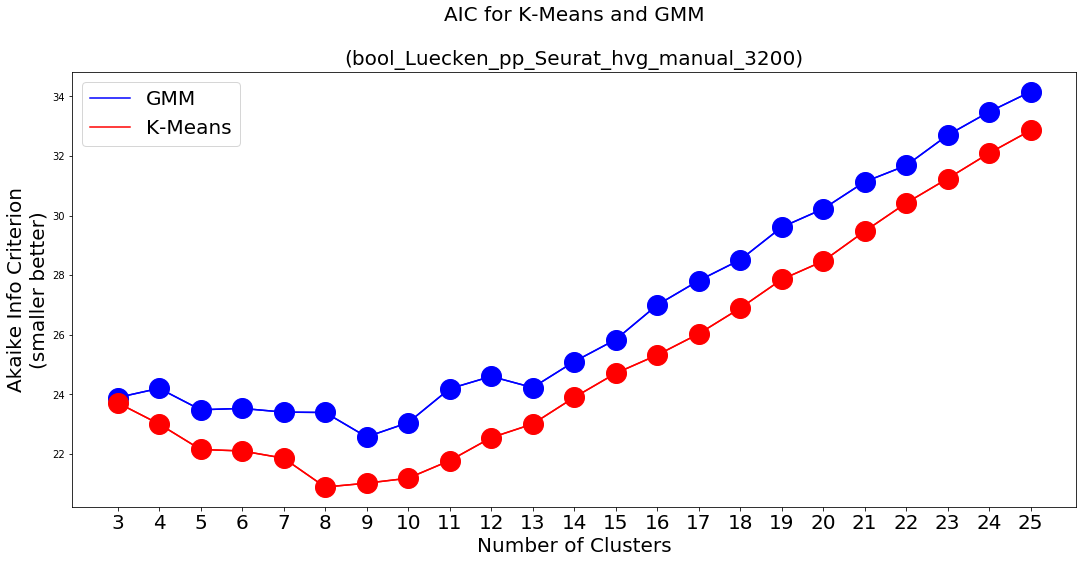

In [33]:
plt.figure(figsize = (18,8))
plt.plot(range(num_clusters), df_ic.iloc[:num_clusters, 2], color='blue', label = "GMM")
plt.plot(range(num_clusters), df_ic.iloc[:num_clusters, 2], color='blue', marker='o' , markersize=20, label='_nolegend_')
plt.plot(range(num_clusters), df_ic.iloc[num_clusters:, 2], color='red', label="K-Means")
plt.plot(range(num_clusters), df_ic.iloc[num_clusters:, 2], color='red', marker='o' , markersize=20, label='_nolegend_')
plt.legend(loc='upper left', fontsize = 20)

plt.title('AIC for K-Means and GMM\n\n({})'.format(hvg_bool_filename), fontsize = 20)
plt.xlabel('Number of Clusters', fontsize = 20)
plt.ylabel('Akaike Info Criterion\n(smaller better)', fontsize = 20)
plt.xticks(range(num_clusters), num_clusters_list, fontsize = 20)
plot_file_name = data_loc + "AIC_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

#### Plot BIC

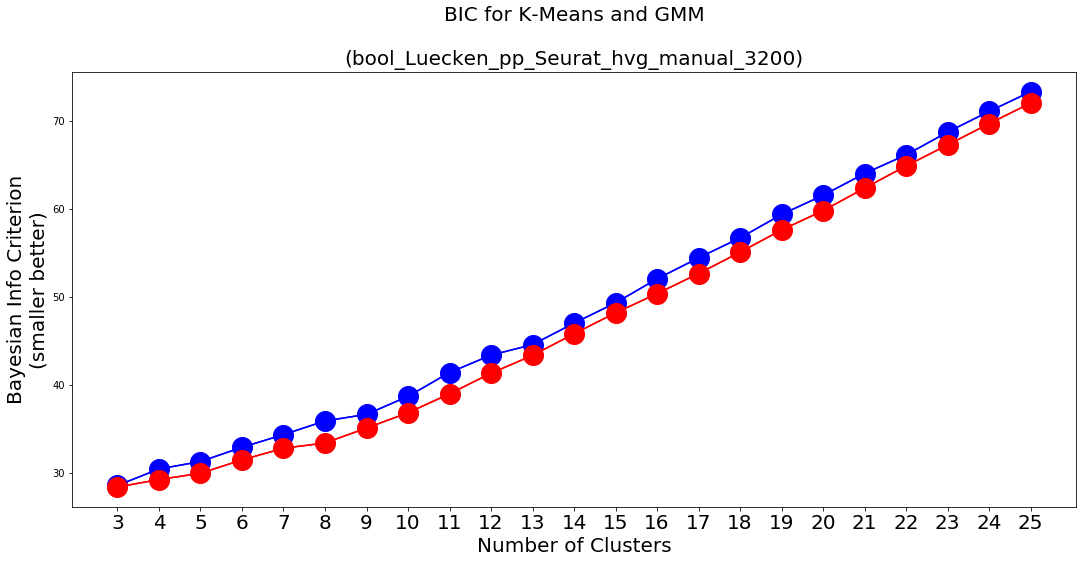

In [34]:
plt.figure(figsize = (18,8))
num_clusters = len(k_range)

plt.plot(range(num_clusters), df_ic.iloc[:num_clusters, 3], color='blue', label="GMM")
plt.plot(range(num_clusters), df_ic.iloc[:num_clusters, 3], color='blue', marker = 'o', markersize=20, label='_nolegend_')
plt.plot(range(num_clusters), df_ic.iloc[num_clusters:, 3], color='red', label="K-Means")
plt.plot(range(num_clusters), df_ic.iloc[num_clusters:, 3], color='red', marker = 'o', markersize=20, label='_nolegend_')


plt.title('BIC for K-Means and GMM\n\n({})'.format(hvg_bool_filename), fontsize = 20)
plt.xlabel('Number of Clusters', fontsize = 20)
plt.ylabel('Bayesian Info Criterion\n(smaller better)', fontsize = 20)
plt.xticks(range(num_clusters), num_clusters_list, fontsize = 20)
plot_file_name = data_loc + "BIC_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

In [35]:
# extract lists of cluster membership from clValid objects
# list of triplets: [cluster method, k, [cluster label values for each observation] ]
cl_label_list = [] 

cl_methods = ro.r('cl_obj_eucl@clMethods') # list of strings of cluster algorithm names
num_clusters_list = list(map(int, ro.r('cl_obj_eucl@nClust'))) # list of integers of number of clusters 


for i in range(1, 10): # kmeans, hierarchical, model, sota, pam, clara, diana, fanny, GMM
    
    # use correct label for the clustering algorithm
    label_name = 'clustering'
    if i  == 1: # kmeans
        label_name = 'cluster'
    elif i == 3: # model
        label_name = 'classification'
    elif i == 4: #sota
        label_name = 'clust'
        
       # loop through 'k' values, i.e. each number of clusters built
    for j in range(int(ro.r('length(cl_obj_eucl@clusterObjs[[1]])') )):
        num_clusters  = num_clusters_list[j]
        

        if i == 2: # extract hierarchical model cluster labels
            label_string = 'cutree(cl_obj_eucl@clusterObjs[[2]], k = ' + str(num_clusters) + ')'
            labels = ro.r(label_string)
            partitions = []
            for cluster in range(1, num_clusters +1):
                partitions.append(np.where(labels == cluster)[0])
            cl_label_list.append([cl_methods[i-1], num_clusters, labels, partitions])
            
        elif i == 7: # extract diana model cluster labels
            label_string = 'cutree(cl_obj_eucl@clusterObjs[[7]], k = ' + str(num_clusters) + ')'
            labels = ro.r(label_string)
            partitions = []
            for cluster in range(1, num_clusters +1):
                partitions.append(np.where(labels == cluster)[0])
            cl_label_list.append([cl_methods[i-1], num_clusters, labels, partitions])
            
        elif i == 9: # extract GMM cluster labels
            
            labels = gmm_labels[j]
            partitions = []
            for cluster in range(1, num_clusters +1):
                partitions.append(np.where(np.array(labels) == cluster)[0])
            cl_label_list.append(["gmm", num_clusters, labels, partitions])
            
        else: # extract kmeans, model, sota, pam, clara, or fanny cluster labels
            label_string = 'cl_obj_eucl@clusterObjs[[' + str(i) + "]][[" + str(j+1) + "]]$" + label_name
            labels = np.array(list(map(int, ro.r(label_string) )))
            partitions = []
            for cluster in range(1, num_clusters +1):
                partitions.append(np.where(labels == cluster)[0])
            cl_label_list.append([cl_methods[i-1], num_clusters, labels, partitions])
        
      

In [36]:
# make names of cluster method and number of clusters for Adjusted Rand,  Normalized Mutual Info and Variation of Info matrices

pd_col_row_names = []
num_k_per_method = int(len(cl_label_list)/9)
num_models = num_k_per_method * 9 #

for i in range(num_models):
    pd_col_row_names.append(cl_label_list[i][0] + str(cl_label_list[i][1]))

#### Declare an extra validity measure, Variation of Information

In [37]:
def variation_of_information(X, Y):
  n = float(sum([len(x) for x in X]))
  sigma = 0.0
  for x in X:
    p = len(x) / n
    for y in Y:
      q = len(y) / n
      r = len(set(x) & set(y)) / n
      if r > 0.0:
        sigma += r * (log(r / p, 2) + log(r / q, 2))
  return abs(sigma)

#### Create matrices of Adjusted Rand, Mutual Info and Variation of Info for all pairs of models built

In [ ]:
# adj_rand_mx want large
# mutual_info_mx want large
# var_info_mx  want small
num_clusters = len(k_range)
adj_rand_mx_eucl = pd.DataFrame(0, index = pd_col_row_names + ["Total"], columns=pd_col_row_names)
mutual_info_mx_eucl = pd.DataFrame(0, index = pd_col_row_names + ["Total"], columns=pd_col_row_names)
var_info_mx_eucl = pd.DataFrame(0, index = pd_col_row_names + ["Total"], columns=pd_col_row_names)

for j in range(num_models):
    for i in range(num_models):
        if i != j:
            adj_rand_mx_eucl.iloc[i,j] = adjusted_rand_score(cl_label_list[i][2], cl_label_list[j][2])
            mutual_info_mx_eucl.iloc[i,j] = normalized_mutual_info_score(cl_label_list[i][2], cl_label_list[j][2])
            var_info_mx_eucl.iloc[i,j] = variation_of_information(cl_label_list[i][3], cl_label_list[j][3])
    adj_rand_mx_eucl.iloc[i+1,j] = adj_rand_mx_eucl.iloc[:i+1,j].sum()
    mutual_info_mx_eucl.iloc[i+1,j] = mutual_info_mx_eucl.iloc[:i+1,j].sum()
    var_info_mx_eucl.iloc[i+1,j] = var_info_mx_eucl.iloc[:i+1,j].sum()

# save dataframe and csv of adjusted rand mx
adj_rand_mx_eucl_file_name = data_loc + 'adj_rand_mx_AE_eucl_' + hvg_bool_filename + '.pickle'
adj_rand_mx_eucl.to_pickle(adj_rand_mx_eucl_file_name)
adj_rand_mx_eucl.to_csv(adj_rand_mx_eucl_file_name + '.csv')
print("\n\nAdjusted Rand Index matrix for Euclidean distance:")
display(adj_rand_mx_eucl)

# save dataframe and csv of mutual info mx
mutual_info_mx_file_name = data_loc + 'mutual_info_mx_AE_eucl_' + hvg_bool_filename + '.pickle'
mutual_info_mx_eucl.to_pickle(mutual_info_mx_file_name)
mutual_info_mx_eucl.to_csv(mutual_info_mx_file_name + '.csv')
print("\n\nMutual Information matrix for Euclidean distance:")
display(mutual_info_mx_eucl)

# save dataframe and csv of variation of info mx
var_info_mx_eucl_file_name = data_loc + 'var_info_mx_AE_eucl_' + hvg_bool_filename + '.pickle'
var_info_mx_eucl.to_pickle(var_info_mx_eucl_file_name)
var_info_mx_eucl.to_csv(var_info_mx_eucl_file_name + '.csv')
print("\n\nVariation of Information matrix for Euclidean distance:")
display(adj_rand_mx_eucl)


### Adjusted rand, mutual info and variation of info plots

In [ ]:

# Adjusted Rand Index plot
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", 
               "tab:olive", "tab:cyan"]
method_list = ["kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny", "gmm"]
points = len(range(k_min, k_max + 1))

plt.figure(figsize = (18,8))
for i in range(9):
    plt.plot(range(k_min, k_max + 1), adj_rand_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             label=method_list[i])
    plt.plot(range(k_min, k_max + 1), adj_rand_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             marker='o' , markersize=10, label='_nolegend_')

plt.xlabel('Clusters', fontsize = 20)

#     plt.yticks("")
plt.xticks(range(k_min, k_max + 1),  range(k_min, k_max + 1), fontsize = 15)
plt.legend(loc='lower right', fontsize = 15)
plt.title('Adjusted Rand Index\n\n({})'.format(hvg_bool_filename), fontsize = 20)

plot_file_name = data_loc + "adj_rand_mx_eucl_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

In [ ]:
# Normalized Mutual Information plot
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", 
               "tab:olive", "tab:cyan"]
method_list = ["kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny", "gmm"]
points = len(range(k_min, k_max + 1))

plt.figure(figsize = (18,8))
for i in range(9):
    plt.plot(range(k_min, k_max + 1), mutual_info_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             label=method_list[i])
    plt.plot(range(k_min, k_max + 1), mutual_info_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             marker='o' , markersize=10, label='_nolegend_')

plt.xlabel('Clusters', fontsize = 20)

#     plt.yticks("")
plt.xticks(range(k_min, k_max + 1),  range(k_min, k_max + 1), fontsize = 15)
plt.legend(loc='lower right', fontsize = 15)
plt.title('Normalized Mutual Information\n\n({})'.format(hvg_bool_filename), fontsize = 20)

plot_file_name = data_loc + "mutual_info_mx_eucl_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

In [ ]:

# Variation of Information plot
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", 
               "tab:olive", "tab:cyan"]
method_list = ["kmeans", "hierarchical", "model", "sota", "pam", "clara", "diana", "fanny", "gmm"]
points = len(range(k_min, k_max + 1))

plt.figure(figsize = (18,8))
for i in range(9):
    plt.plot(range(k_min, k_max + 1), var_info_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             label=method_list[i])
    plt.plot(range(k_min, k_max + 1), var_info_mx_eucl.iloc[-1, i*points:(i+1)*points], color=colour_list[i], 
             marker='o' , markersize=10, label='_nolegend_')

plt.xlabel('Clusters', fontsize = 20)

#     plt.yticks("")
plt.xticks(range(k_min, k_max + 1),  range(k_min, k_max + 1), fontsize = 15)
plt.legend(loc='lower right', fontsize = 15)
plt.title('Variation of Information\n\n({})'.format(hvg_bool_filename), fontsize = 20)

plot_file_name = data_loc + "var_info_mx_eucl_" + hvg_bool_filename + ".png"
plt.savefig(plot_file_name, bbox_inches='tight')

### Make plots of validity measures for each cluster method and number of clusters

In [ ]:
# to make the transfer from R format to Python, re-import the R summary which was saved as a txt file
summary_filename = data_loc + " cl_obj_eucl_SUMMARY_ " + hvg_bool_filename + " .txt"
data = pd.read_csv(summary_filename, header = 5)
data = data.iloc[:56] # remove extra text from R summary file

In [ ]:
# Validity Measure plots
colour_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:olive", "tab:cyan"]
vm_list = ["Average Proportion of Non-Overlap", "Average Distance", 'Average Distance Between Means', 'Figure of Merit', 'Connectivity', 'Dunn Index', 'Silhouette Width']
 
for vm in range(len(vm_list)):
    vm_df = pd.DataFrame(0, index = cl_methods, columns=k_range) # row for each cluster method, column for each cluster count
    for i in range(0, len(cl_methods)):
        scores = data.iloc[i * 7 + vm][0].replace(",", "").split(" ") # remove commas, *7 because there are seven validity measures
        scores = list(filter(None, scores)) # remove empty string and turn into a list
        scores = scores[-num_clusters:] # remove the cluster method and validity measure names from start of list
        if scores[0] == "NA":
            scores = [0] * len(k_range)
        else:
           scores = list(map(float,scores)) # change strings to floats 
        vm_df.iloc[i, :] = scores
    plt.figure(figsize = (18,8))
    for i in range(8):
        if i == 7:
            if vm_df.iloc[-1, 0] == 0:
                continue # sometimes fuzzy clustering doesn't give labels
        else:
            plt.plot(range(k_min, k_max + 1), vm_df.iloc[i, :], color=colour_list[i])
            plt.plot(range(k_min, k_max + 1), vm_df.iloc[i, :], color=colour_list[i], marker='o' , markersize=10, label='_nolegend_')
                    
    plt.xlabel('Clusters', fontsize = 20)

    if vm == 5 or vm == 6:
        plt.ylabel('larger better', fontsize = 20, rotation = 90)
    else:
        plt.ylabel('smaller better', fontsize = 20)

    plt.xticks(range(k_min, k_max + 1),  range(k_min, k_max + 1), fontsize = 15)
    plt.legend(loc='upper right', fontsize = 15)
    plt.title('{}\n\n({})'.format(vm_list[vm], hvg_bool_filename), fontsize = 20)

    plot_file_name = data_loc + vm_list[vm] + "_" + hvg_bool_filename + ".png"
    plt.savefig(plot_file_name, bbox_inches='tight')